In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import csv

from gensim.models import Word2Vec

from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from time import time

In [2]:
# Read the h-indices
df = pd.read_csv('../Data/train.csv', dtype={'author': np.int64, 'hindex': np.float32})

# Load the graph
G = nx.read_edgelist('../Data/coauthorship.edgelist', delimiter=' ', nodetype=int)

In [3]:
# Creates a subgraph of the co-authorship graph for testing the time performance of some methods
subnodes = [k for i,k in enumerate(G) if i < 20000]
subG = G.subgraph(subnodes)
#nx.write_edgelist(subG, '../Data/50000_coauthorship_tab.edgelist', delimiter='\t', data = False)

In [4]:
# Computes some graph properties
core_num = nx.core_number(G)
print("Core number done")
average_neighbor_deg = nx.average_neighbor_degree(G)
print("Average neighbor degree done")
eigenvector_cen = nx.eigenvector_centrality(G)
print("Eigenvector centrality done")
page_rank = nx.pagerank(G)
print("Pagerank done")

Core number done
Average neighbor degree done
Eigenvector centrality done
Pagerank done


In [26]:
# Loads precomputed features from files

best_word = {}
with open('../Data/author_best.csv', encoding='utf-8') as f:
    for row in csv.reader(f):
        best_word[int(row[0])] = float(row[1])

sci_words = {}
with open('../Data/score.csv', encoding='utf-8') as f:
    for row in csv.reader(f):
        sci_words[int(row[0])] = float(row[1])

nb_papers = {}
with open('../Data/nb_articles.csv', encoding='utf-8') as f:
    for row in csv.reader(f):
        nb_papers[int(row[0])] = float(row[1])
        
ex_ratio = {}
with open('../Data/ex_ratio.csv', encoding='utf-8') as f:
    for row in csv.reader(f):
        ex_ratio[int(row[0])] = float(row[1])
        
ex_num = {}
with open('../Data/ex_num.csv', encoding='utf-8') as f:
    for row in csv.reader(f):
        ex_num[int(row[0])] = float(row[1])

In [27]:
# Modification to the number of abstract feature
for key in nb_papers.keys():
    if nb_papers[key] == 5:
        nb_papers[key] = 12.36894318 #mean

Let's take a quick look at the data

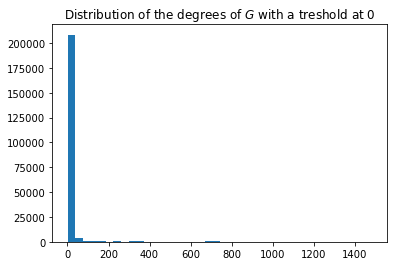

In [9]:
treshold = 0

# Degree distribution
l = []
for node in G:
    if G.degree(node) > treshold:
        l.append(G.degree(node))

plt.hist(l, bins = 40)
plt.title("Distribution of the degrees of $G$ with a treshold at {}".format(treshold))
print()

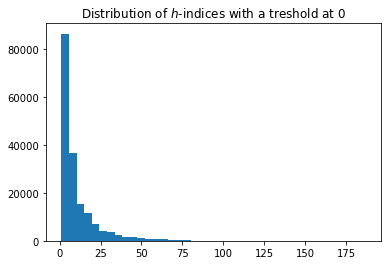

In [8]:
treshold = 0

# Distribution of h-indices
hindex = df['hindex']
plt.hist(hindex[hindex > treshold], bins = 40)
plt.title("Distribution of $h$-indices with a treshold at {}".format(treshold))
print()

### Test-Train split

We split the dataframe into a dataframe for training and a dataframe for testing

In [10]:
# Fraction of samples in the training set
train_frac = 0.7
# Split the dataframe into train and test dataframes
df_train = df.sample(frac = train_frac)
df_test = df.drop(df_train.index)

### Baseline

First, we try to reproduce the score of the baseline using only the training dataset (because we do not have the answers for the testing dataset).

In [11]:
# Builds the feature vectors and target vector from the dataframe
# Here we reproduce the features of the baseline
def featvecs_baseline(df):
    n = df.shape[0]
    X = np.zeros((n,2))
    y = np.zeros(n)
    for i, x in zip(range(n), df.iterrows()):
        _, row = x
        X[i,0] = G.degree(row['author'])
        X[i,1] = core_num[row['author']]
        y[i] = row['hindex']
    return X,y

In [12]:
# Fitting a lasso model like in the baseline

X_train, y_train = featvecs_baseline(df_train)
print("Training features built")

X_test, y_test = featvecs_baseline(df_test)
print("Testing features built\n")

reg = Lasso(alpha = 0.1)
reg.fit(X_train, y_train)
print("Model fitted\n")

y_pred = reg.predict(X_test)
print("MSE: {:.4}".format(mean_squared_error(y_pred, y_test)))

Training features built
Testing features built

Model fitted

MSE: 130.5


# Basic graph features

To start, we use basic graph features (degree, core number, pagerank,...) to try out a lasso model and a neural network model.

In [37]:
# Builds the feature vectors and target vector from the dataframe

n_feat_basic = 5

def featvecs_basic(df):
    
    n = df.shape[0]
    X = np.zeros((n, n_feat_basic))
    y = np.zeros((n, 1))
    
    for i, x in enumerate(df.iterrows()):
        
        _, row = x
        node = row['author']
        
        X[i, 0] = G.degree(node) ** 0.2
        X[i, 1] = core_num[node]
        X[i, 2] = average_neighbor_deg[node]
        X[i, 3] = eigenvector_cen[node]
        X[i, 4] = page_rank[node]
        
        y[i] = row['hindex']
    
    return X,y

In [30]:
# Fitting a lasso model

X_train, y_train = featvecs_basic(df_train)
print("Training features built")

X_test, y_test = featvecs_basic(df_test)
print("Testing features built")

reg = Lasso(alpha = 0.1, max_iter = 1e5)
reg.fit(X_train, y_train)
print("Model fitted\n")

y_pred = reg.predict(X_test)
print("MSE: {:.4}".format(mean_squared_error(y_pred, y_test)))

Training features built
Testing features built
Model fitted

MSE: 114.2


##### Feature normalization

One big problem here is that the features are on very different orders of magnitude. Normalizing the features does not significantly improve the performance of the model, but helps compare features the lasso coefficients.

In [17]:
# Fitting a lasso model

X_train, y_train = featvecs_basic(df_train)
print("Training features built")

X_test, y_test = featvecs_basic(df_test)
print("Testing features built")

# Normalizing features (assumes that X_train is larger than X_test)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

reg = Lasso(alpha = 0.1, max_iter = 1e5)
reg.fit(X_train, y_train)
print("Model fitted\n")

y_pred = reg.predict(X_test)
print("MSE: {:.4}".format(mean_squared_error(y_pred, y_test)))

Training features built
Testing features built
Model fitted

MSE: 111.2


##### With a neural network

Here we use the same features to train a fully connected neural network. We will see that it does perform better than the lasso model, but only for normalized features. Since the neural network has more parameters to optimize, its makes sense that it would cost it more to rescale entire features.

In [56]:
# Builds the feature vectors
X_train, y_train = featvecs_basic(df_train)
X_test, y_test = featvecs_basic(df_test)

# Normalizing features (assumes that X_train is larger than X_test)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Conversion to torch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

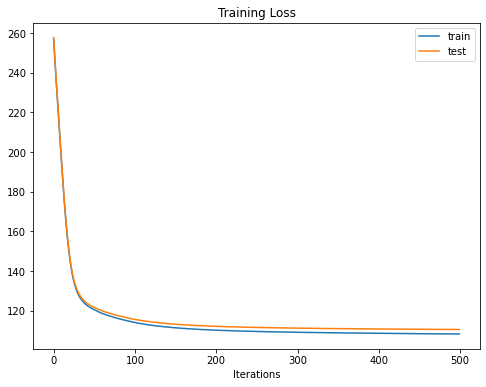

MSE: 110.6


In [57]:
model = nn.Sequential(nn.Linear(n_feat_basic, 40), nn.Tanh(), nn.Linear(40, 1))

loss_function = nn.MSELoss()
other_loss = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.005)

train_losses = []
test_losses = []

for epoch in range(500):
    
    # Update test loss
    output_test = model(X_test)
    test_losses.append(other_loss(output_test, y_test).item())
    
    # Optimization step
    output = model.forward(X_train)
    loss = loss_function(output, y_train)
    optimizer.zero_grad() #required since pytorch accumulates the gradients
    loss.backward() #backpropagation step
    optimizer.step() #update the parameters
    
    # Update train loss
    train_losses.append(loss.item())
    
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(train_losses, label = 'train')
ax.plot(test_losses, label = 'test')
ax.set_title("Training Loss")
ax.set_xlabel("Iterations")
plt.legend()
plt.show()

print("MSE: {:.4}".format(min(test_losses)))

# Node2Vec embeddings as features

Here we try to use the node2vec embedding of nodes as a node feature for a lasso model.

In [36]:
# Loads the embeddings
model = Word2Vec.load("../HeavyData/model2.model")
n_dim = len(model.wv[str(2336566022)])
embedding = np.zeros((G.number_of_nodes(), n_dim))
for idx, node in enumerate(G.nodes()):
    embedding[idx, :] = model.wv[str(node)]

In [40]:
# Builds the feature vectors and target vector from the dataframe

n_feat_node2vec = n_dim

def featvecs_node2vec(df):
    
    n = df.shape[0]
    X = np.zeros((n, n_feat_node2vec))
    y = np.zeros((n, 1))
    
    idx = list(G.nodes())
    rev_idx = {idx[i]: i for i in range(len(idx))}
    
    for i, x in enumerate(df.iterrows()):
        
        _, row = x
        node = row['author']
        
        # Node2Vec features
        X[i,:] = embedding[rev_idx[node], :]
        
        y[i] = row['hindex']
        
    return X,y

In [41]:
# Building train features
X_train, y_train = featvecs_node2vec(df_train)
print("Training features built")

# Building test features
X_test, y_test = featvecs_node2vec(df_test)
print("Testing features built")

# We do not normalize the node2vec embedding

# The lasso model
reg = Lasso(alpha = 0.1, max_iter = 1e5)
reg.fit(X_train, y_train)
print("Model fitted\n")

# Evaluating the model
y_pred = reg.predict(X_test)
print("MSE: {:.4}".format(mean_squared_error(y_pred, y_test)))

Training features built
Testing features built
Model fitted

MSE: 143.3


It is not completely useless, but is far from the performance of the basic graph features.

# All features

We do not bother using the node2vec features since they have proved not so useful.

In [44]:
# Builds the feature vectors and target vector from the dataframe

n_feat_all = 10

def featvecs_all(df):
    
    n = df.shape[0]
    X = np.zeros((n, n_feat_all))
    y = np.zeros((n, 1))
    
    for i, x in enumerate(df.iterrows()):
        
        _, row = x
        node = row['author']
        
        # All the features
        X[i, 0] = G.degree(node) ** 0.2
        X[i, 1] = core_num[node]
        X[i, 2] = average_neighbor_deg[node]
        X[i, 3] = eigenvector_cen[node]
        X[i, 4] = page_rank[node]
        X[i, 5] = best_word[node]
        X[i, 6] = sci_words[node]
        X[i, 7] = nb_papers[node]
        X[i, 8] = ex_ratio[node]
        X[i, 9] = ex_num[node]
        
        y[i] = row['hindex']
        
    return X,y

##### With a lasso model

In [45]:
# Fitting a lasso model

X_train, y_train = featvecs_all(df_train)
print("Training features built")

X_test, y_test = featvecs_all(df_test)
print("Testing features built")

# Normalizing features (assumes that X_train is larger than X_test)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

reg = Lasso(alpha = 0.1, max_iter = 1e5)
reg.fit(X_train, y_train)
print("Model fitted\n")

y_pred = reg.predict(X_test)
print("MSE: {:.4}".format(mean_squared_error(y_pred, y_test)))

Training features built
Testing features built
Model fitted

MSE: 97.87


##### With a fully connected neural network

In [51]:
# Builds the feature vectors
X_train, y_train = featvecs_all(df_train)
X_test, y_test = featvecs_all(df_test)

# Normalizing features (assumes that X_train is larger than X_test)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Conversion to torch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

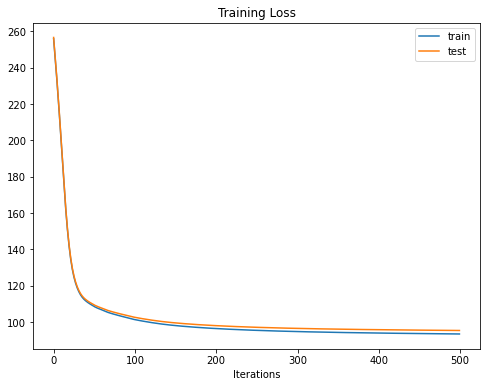

MSE: 95.35


In [55]:
model = nn.Sequential(nn.Linear(n_feat_all, 40), nn.Tanh(), nn.Linear(40, 1))

loss_function = nn.MSELoss()
other_loss = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.005)

train_losses = []
test_losses = []

for epoch in range(500):
    
    # Update test loss
    output_test = model(X_test)
    test_losses.append(other_loss(output_test, y_test).item())
    
    # Optimization step
    output = model.forward(X_train)
    loss = loss_function(output, y_train)
    optimizer.zero_grad() #required since pytorch accumulates the gradients
    loss.backward() #backpropagation step
    optimizer.step() #update the parameters
    
    # Update train loss
    train_losses.append(loss.item())
    
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(train_losses, label = 'train')
ax.plot(test_losses, label = 'test')
ax.set_title("Training Loss")
ax.set_xlabel("Iterations")
plt.legend()
plt.show()

print("MSE: {:.4}".format(min(test_losses)))

# END OF CLEAN

# The last `featvecs` function

In [35]:
# Builds the feature vectors and target vector from the dataframe

other_feat = 8
n_feat = other_feat + n_dim

def featvecs_node2vec(df, get_y = True):
    
    n = df.shape[0]
    X = np.zeros((n, n_feat))
    y = np.zeros((n, 1))
    
    idx = list(G.nodes())
    rev_idx = {idx[i]: i for i in range(len(idx))}
    
    for i, x in enumerate(df.iterrows()):
        
        _, row = x
        node = row['author']
        
        # Standard node features
        X[i, 0] = G.degree(node) ** 0.2
        X[i, 1] = core_num[node]
        X[i, 2] = average_neighbor_deg[node]
        X[i, 3] = eigenvector_cen[node]
        X[i, 4] = page_rank[node]
        X[i, 5] = best_word[node]
        X[i, 6] = sci_words[node]
        X[i, 7] = nb_papers[node]
        X[i, 8] = ex_ratio[node]
        X[i, 9] = ex_num[node]
        
        # Node2Vec features
        X[i, other_feat:] = embedding[rev_idx[node], :]
        
        if get_y:
            y[i] = row['hindex']
    if get_y:
        return X,y
    return X

### Hard limit

In [26]:
for i in range(len(y_pred)):
    if oldX[i] < 5 and y_pred[i] > oldX[i]:
        #print((y_pred[i],X_test[i, 7]))
        y_pred[i] = oldX[i]
print("MSE: {:.4}".format(mean_squared_error(y_pred, y_test)))

MSE: 92.01


### Final submission

In [27]:
# Building train features
X_train, y_train = featvecs_node2vec(df)
print("Training features built")

# Read the h-indices
df2 = pd.read_csv('../Data/test.csv', dtype={'author': np.int64, 'hindex': np.float32})

# Building test features
X_pred = featvecs_node2vec(df2, False)
print("Testing features built")

oldX = X_test[:,7].copy()

Training features built
Testing features built


In [28]:
# We do not normalize the node2vec embedding
scaler = StandardScaler().fit(X_train[:,:-n_dim])
X_train[:,:-n_dim] = scaler.transform(X_train[:,:-n_dim])
X_test[:,:-n_dim] = scaler.transform(X_test[:,:-n_dim])

# The lasso model
reg = Lasso(alpha = 0.1, max_iter = 1e5)
reg.fit(X_train, y_train)
print("Model fitted\n")

#Make the predictions
y_pred = reg.predict(X_test)

Model fitted



In [29]:
#Implement the hard limit
for i in range(len(y_pred)):
    if oldX[i] < 5 and y_pred[i] > oldX[i]:
        #print((y_pred[i],X_test[i, 7]))
        y_pred[i] = oldX[i]
    if y_pred[i] < 1:
        y_pred[i] = 1

In [30]:
y_pred

array([1., 1., 1., ..., 1., 1., 1.])

In [31]:
with open('../Data/submission2.csv', 'w', encoding='utf-8') as f:
    f.write('author,"hindex"\n')
    for i in range(len(y_pred)):
        f.write('%s,"%s"\n'%(df2['author'][i],y_pred[i]))

KeyError: 43560

In [ ]:
min(y_pred)

### Community training

In [ ]:
# Read
lei_mem = []

with open('../Data/partition.txt', 'r') as filehandle:
    for line in filehandle:
        lei_mem.append(line[:-1])
        
idx = list(G.nodes())
author_to_community = {}
for i,ii in enumerate(idx):
    author_to_community[ii] = int(lei_mem[i])

In [ ]:
community = {}
for author in df_train['author']:
    c = author_to_community[author]
    if c not in community.keys():
        community[c] = [author]
    else:
        community[c].append(author)

In [ ]:
#train 1 model for each community
reg_dict = {}
scaler = {}
for c in community.keys():
    dfc = df_train[df_train.author.isin(community[c])]
    X_train, y_train = featvecs_node2vec(dfc)
    s = StandardScaler().fit(X_train[:,:-n_dim])
    X_train[:,:-n_dim] = s.transform(X_train[:,:-n_dim])
    scaler[c] = s
    reg_dict[c] = Lasso(alpha = 0.1, max_iter = 1e5)
    reg_dict[c] = reg_dict[c].fit(X_train, y_train)

In [ ]:
indices = {}
test = {}
for i in range(len(X_test)):
    c = author_to_community[list(df_test['author'])[i]]
    if c not in indices.keys():
        indices[c] = [i]
        test[c] = [X_test[i]]
    else:
        indices[c].append(i)
        test[c].append(X_test[i])

In [ ]:
y = {}        
for c in test.keys():
    test[c] = np.array(test[c])
    #test[c][:,:-n_dim] = scaler[c].transform(test[c][:,:-n_dim])
    y[c] = reg_dict[c].predict(test[c])     
for c in y.keys():
    for i in range(len(y[c])):
        y_pred[indices[c][i]] = y[c][i]

In [ ]:
for i in range(len(y_pred)):
    if oldX[i] < 5 and y_pred[i] > oldX[i]:
        #print((y_pred[i],X_test[i, 7]))
        y_pred[i] = oldX[i]
    if y_pred[i] < 1:
        y_pred[i] = 1

In [ ]:
print("MSE: {:.4}".format(mean_squared_error(y_pred, y_test)))

### Community final submission

In [ ]:
indices = {}
test = {}
for i in range(len(X_test)):
    c = author_to_community[list(df2['author'])[i]]
    if c not in indices.keys():
        indices[c] = [i]
        test[c] = [X_test[i]]
    else:
        indices[c].append(i)
        test[c].append(X_test[i])

scale

In [ ]:
y = {}        
for c in test.keys():
    test[c] = np.array(test[c])
    #test[c][:,:-n_dim] = scaler[c].transform(test[c][:,:-n_dim])
    y[c] = reg_dict[c].predict(test[c])     
for c in y.keys():
    for i in range(len(y[c])):
        y_pred[indices[c][i]] = y[c][i]

In [ ]:
for i in range(len(y_pred)):
    if oldX[i] < 5 and y_pred[i] > oldX[i]:
        #print((y_pred[i],X_test[i, 7]))
        y_pred[i] = oldX[i]
    if y_pred[i] < 1:
        y_pred[i] = 1

In [112]:
idx = list(G.nodes())

In [126]:
max(community.keys())

246

In [ ]:
with open('../Data/submission2.csv', 'w', encoding='utf-8') as f:
    f.write('author,"hindex"\n')
    for i in range(len(y_pred)):
        f.write('%s,"%s"\n'%(list(df2['author'])[i],y_pred[i]))